# Machine Learning I, Programming Exercise 8

## 1. Randomness & SGD
As you have seen in the lecture, we can instantiate most machine learning models as special cases of a *generalized regression* problem by choosing a regularizer, a feature map and a loss function. For example, linear SVMs and a deep neural networks both fit into this general framework.

In fact, this theoretical observation carries over (at least partly) into the real world, which we will show by implementing the linear SVM in PyTorch:
1. Re-use your existing code from programming exercise 5.1 to implement a linear SVM in PyTorch. This is just a matter of finding the correct "network" architecture, loss function and regularizer. For your convenience, here is the soft-margin SVM optimization problem again:
\begin{equation*}
    \min_{\mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}} \frac{1}{2} \lVert \mathbf{w} \rVert^2 + \frac{C}{n} \sum_{i=1}^{n} \max\left(0, 1 - y^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)} + b)\right)
\end{equation*}
Note that the SVM should have only one output to distinguish between two classes, so you might need to adapt your training and prediction code slightly. However, make sure to keep the basic training routine intact:
    * Shuffle the data
    * Pass through all of the shuffled data in mini-batches and update the weights
    * Repeat the previous steps for a given number of epochs

Note that this procedure is slightly different from the linear SVM that we implemented in programming exercise 2: Instead of re-sampling a random batch with replacement before every update, we shuffle the data before each epoch and then process all of the data in batches *without* replacement. Technically, we are no longer using the textbook *stochastic gradient descent* to solve our optimization problem, but a method that is sometimes called *random reshuffling* in the optimization literature. We could also shuffle just once before training and then visit the data in the same order in every epoch, or we could not shuffle at all. While the latter two methods don't have a specific name for themselves, all three are special cases of a method usually called [*iterated gradient*](https://arxiv.org/pdf/1507.01030.pdf).

Theoretically, these algorithms are indeed different and [it has been shown](https://arxiv.org/pdf/1510.08560.pdf) that, depending on the problem at hand, one algorithm might be strictly superior to another. But this is not a theory exercise, so we will try and see if we can find any empirical evidence showing the influence of the sampling strategy instead:
2. Modify your training loop s.t. an additional option `shuffle` can be passed to the `TorchClassifier` class. Your implementation should support the four sampling startegies that we discussed above:
    * `shuffle='never'`: Don't shuffle the data at all and just process it in the same, given order in every epoch.
    * `shuffle='once'`: Shuffle the data once before the actual training loop and then visit the data in the same order in every subsequent epoch.
    * `shuffle='epoch'`: Re-shuffle the data before each epoch.
    * `shuffle='resample'`: Sample a batch from the training data with replacement before each gradient update.


3. Choose a batch size of $B=20$, $C=2$ and use a step size of $0.01$ to train your SVM implementation on the given toy dataset for 15 epochs. You should train one SVM instance for each of the four algorithms from 2 and compare the results in a plot. Can you explain the results of your training?


4. Compute and record the loss over the current batch of training data before each gradient update. To keep the curves from becoming too messy, you should keep a running mean of the values and reset it at the end of each epoch. After re-running this experiment for a few times, would you say that some of the algorithms converge faster than others on this specific problem?


5. How do the results change if you use different values for $B$ and $C$? Feel free to experiment and then try to make sense of your results.

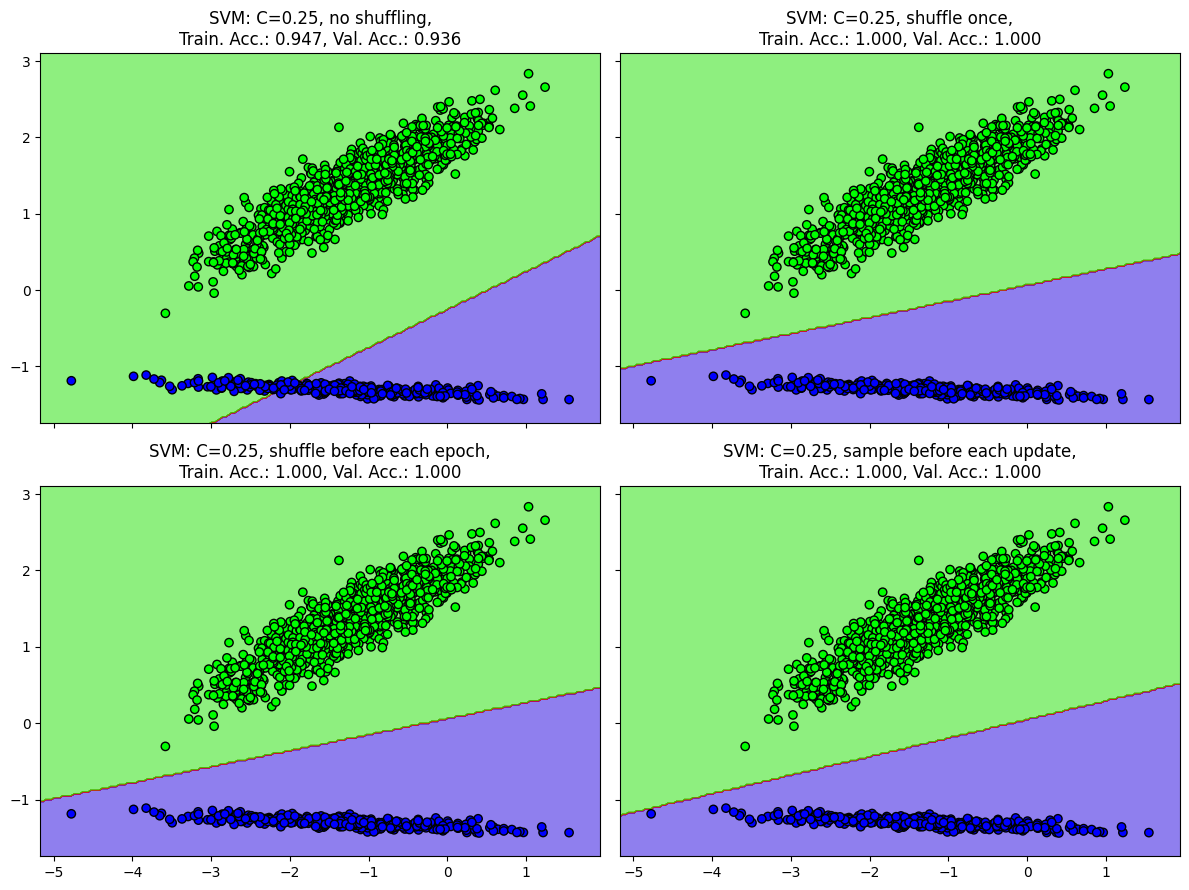

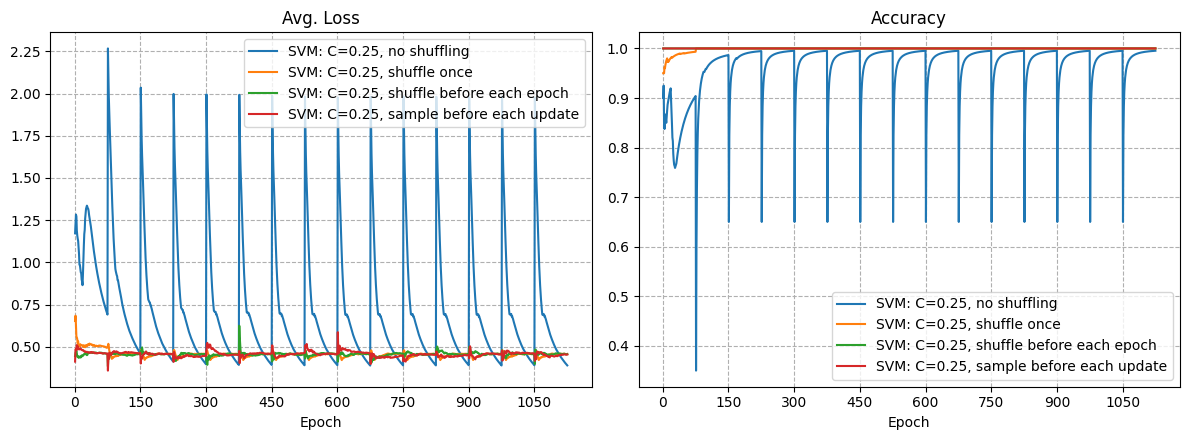

In [6]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

class LinearSVM(torch.nn.Module):
    def __init__(self, in_features=2, bias=True):
        super(LinearSVM, self).__init__()
       
        self.linear_layer = torch.nn.Linear(in_features, 1, bias=bias)

    def forward(self, x):
        return self.linear_layer(x)
    
class HingeLoss(torch.nn.Module):
    def forward(self, pred, target):
        return torch.mean(torch.clamp(1 - target.squeeze(-1)*pred.squeeze(-1), min=0))
    
class SVMLoss(torch.nn.Module):
    def __init__(self, model, C=1):
        super(SVMLoss, self).__init__()
        
        self.model = model
        self.C = C
        self.loss = HingeLoss()
    
    def forward(self, pred, target):
        l = self.C * self.loss(pred, target) \
            + 0.5*torch.dot(self.model.linear_layer.weight.flatten(), self.model.linear_layer.weight.flatten())
        return l

class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, torch_model, loss, optimizer_class, device, step_size=0.001, 
                 batch_size=64, epochs=20, shuffle='once'):
        super(TorchClassifier, self).__init__()
        
        self.torch_model = torch_model.to(device)
        self.loss = loss.to(device)
        if not callable(step_size):
            _step = lambda it: step_size if it<0 else 1
        else:
            _step = step_size
        self.optimizer = optimizer_class(torch_model.parameters(), lr=_step(-1))
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, _step)
        self.device = device
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle

    def fit(self, X, y):
        if self.shuffle == 'resample':
            return self.fit_sgd(X, y)
        
        self.torch_model.train()
        num_batches = (X.shape[0] + self.batch_size - 1) // batch_size
        
        if self.shuffle not in (False, 'never'):
            # Shuffle Data
            indices = np.random.permutation(X.shape[0])
            X = X[indices]
            y = y[indices]
        
        history = dict(train_loss=[], train_acc=[])
        for e in range(self.epochs):
            if self.shuffle == 'epoch':
                # Shuffle Data
                indices = np.random.permutation(X.shape[0])
                X = X[indices]
                y = y[indices]
            
            correct, total, avg_loss = 0, 0, 0
            for i in range(num_batches):
                start = i*batch_size
                end = min((i+1)*batch_size, X.shape[0])
                X_batch = torch.tensor(X[start:end], dtype=torch.get_default_dtype()).to(self.device)
                y_batch = torch.tensor(y[start:end], dtype=torch.int64).to(self.device)
                
                self.optimizer.zero_grad()
                res = self.torch_model(X_batch)
                l = self.loss(res, y_batch)
                l.backward()
                self.optimizer.step()
                self.scheduler.step()
                total += X_batch.shape[0]
                avg_loss += l.data.cpu().numpy() * X_batch.shape[0]
                correct += torch.sum(torch.sign(res).squeeze(-1) == y_batch).data.cpu().numpy()
                history['train_loss'].append(avg_loss / total)
                history['train_acc'].append(correct / total) 
        
        return history
    
    def fit_sgd(self, X, y):
        from random import sample
        self.torch_model.train()
        num_batches = (X.shape[0] + self.batch_size - 1) // batch_size
        num_updates = self.epochs * num_batches
        
        history = dict(train_loss=[], train_acc=[])
        correct, total, avg_loss = 0, 0, 0
        for t in range(num_updates):
            # Sample Data
            indices = sample(range(X.shape[0]), self.batch_size)
            X_batch = X[indices]
            y_batch = y[indices]
            X_batch = torch.tensor(X_batch, dtype=torch.get_default_dtype()).to(self.device)
            y_batch = torch.tensor(y_batch, dtype=torch.int64).to(self.device)

            self.optimizer.zero_grad()
            res = self.torch_model(X_batch)
            l = self.loss(res, y_batch)
            l.backward()
            self.optimizer.step()
            self.scheduler.step()
            total += X_batch.shape[0]
            avg_loss += l.data.cpu().numpy() * X_batch.shape[0]
            correct += torch.sum(torch.sign(res).squeeze(-1) == y_batch).data.cpu().numpy()
            history['train_loss'].append(avg_loss / total)
            history['train_acc'].append(correct / total)            
            if t % num_batches == num_batches-1:
                correct, total, avg_loss = 0, 0, 0
        
        return history

    def predict(self, X):
        Y_pred = np.empty(shape=(X.shape[0],), dtype=np.int64)
        
        self.torch_model.eval()
        num_batches = (X.shape[0] + self.batch_size - 1) // batch_size
        for i in range(num_batches):
            start = i*batch_size
            end = min((i+1)*batch_size, X.shape[0])
            X_batch = torch.tensor(X[start:end], dtype=torch.get_default_dtype()).to(self.device)

            res = self.torch_model(X_batch)
            res = torch.sign(res)
            Y_pred[start:end] = res.data.cpu().numpy().squeeze()
        
        return Y_pred
    
def plot_history(history):
    # Plot training and validation curves for avg. loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    for (name, hist) in history:
        data = [('Avg. Loss', hist['train_loss']), 
                ('Accuracy', hist['train_acc'])]
        for ax, (metric, curve) in zip(axes, data):
            ax.set_title(metric)
            ax.set_xlabel('Epoch')
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            ax.grid(linestyle='dashed')
            ax.plot(range(1, len(curve)+1), curve, label=name)
            ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
# Generate toy data
n = 2000
n_classes = 2
X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=n_classes, weights=(0.25, 0.75),
                           flip_y=0, class_sep=1.3, shuffle=False, n_clusters_per_class=1, random_state=1234)
Y *= 2; Y -= 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)
# Sort the training data according to class labels. This is not a step you should ever do,
# we just want to simulate a dataset that exists sorted on disk and is read in sequentially
ind = np.argsort(Y_train)
X_train = X_train[ind]
Y_train = Y_train[ind]

optimizer = torch.optim.SGD
# Change this to 'cuda' if you can and want to use a GPU for training
# Otherwise, you can completely ignore this parameter
device = torch.device('cpu')  
batch_size=20
epochs = 15

w, b = None, None
def get_classifier(C=1, step_size=0.001, shuffle='once'):
    global w, b
    clf = LinearSVM(in_features = X.shape[1])
    if w is None and b is None:
        w = clf.linear_layer.weight.data
        b = clf.linear_layer.bias.data
    else:
        clf.linear_layer.weight.data = w
        clf.linear_layer.bias.data = b
    loss = SVMLoss(clf, C=C)
    return TorchClassifier(clf, loss, optimizer, device, step_size=step_size, 
                           batch_size=batch_size, epochs=epochs, shuffle=shuffle)
classifiers = [
    ('SVM: C=0.25, no shuffling',
     get_classifier(C=2, step_size=0.01, shuffle='never')),
    ('SVM: C=0.25, shuffle once',
     get_classifier(C=2, step_size=0.01, shuffle='once')),
    ('SVM: C=0.25, shuffle before each epoch',
     get_classifier(C=2, step_size=0.01, shuffle='epoch')),
    ('SVM: C=0.25, sample before each update',
     get_classifier(C=2, step_size=0.01, shuffle='resample'))
]

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(X, axis=0)
x_min, y_min = np.min(X, axis=0)
x_min, x_max = x_min - (x_max - x_min) * 0.0625, x_max + (x_max - x_min) * 0.0625
y_min, y_max = y_min - (y_max - y_min) * 0.0625, y_max + (y_max - y_min) * 0.0625
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# Get test array from grid
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
rows = (len(classifiers)+1)//2
history = []
fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True, figsize=(12, 4.5*rows))
for (name, clf), ax in zip(classifiers, axes.ravel()):
    hist = clf.fit(X_train, Y_train)
    history.append((name, hist))
    score = clf.score(X_test, Y_test)
    train_score = clf.score(X_train, Y_train)
    grid_out = clf.predict(grid_input).reshape(grid_x.shape)

    ax.set_title('%s,\nTrain. Acc.: %.3f, Val. Acc.: %.3f' % (name, train_score, score))
    ax.contourf(grid_x, grid_y, grid_out, alpha=0.5, cmap=plt.cm.brg)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap, edgecolor='k')
plt.tight_layout()
plt.show()
plt.close(fig)

plot_history(history)

## 2. Ridge Regression with the LOOCV Trick
In the lecture, you have seen that leave-one-out cross validation can be performed very efficiently for ridge regression. Indeed, the solution 
\begin{equation*}
    \mathbf{w}_{\text{RR}} := \operatorname{arg\ min}_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2} \lVert \mathbf{w} \rVert^2 + \frac{C}{n} \sum_{i=1}^{n} \left(\mathbf{w}^T\mathbf{x}^{(i)} - y^{(i)}\right)^2
\end{equation*}
for ridge regression and also the root means squared error (RMSE) in LOOCV have a closed form and therefore it is not necessary to use an iterative optimization procedure. Note that this formulation also allows for a *bias*: We can simply add a constant feature to our data, effectively turning $w_{d+1}$ into a bias parameter.

Your tasks will be the following:
1. Implement the LOOCV trick as it is presented in the lecture and use this to find the best value for the regularization constant $C$ from a given set. Then, use this best value to find the solution $\mathbf{w}_{\text{RR}}$ over the whole training dataset. We will use [Boston Housing](https://scikit-learn.org/stable/datasets/index.html#boston-dataset) as the dataset, which is already available in Scikit-Learn and was also briefly introduced in the lecture. As always, your training code should be wrapped in a class `LOOCVRidge` that conforms to the standard Scikit-Learn API. **Hint:** It is highly recommended that you standardize the data before performing ridge regression on it.
2. One great advantage of a linear model such as ridge regression is that it is very easy to interpret. After training, print the resulting solution $\mathbf{w}_{\text{RR}}$ and try to find out how much of an impact each feature has on the result. Now check [the documentation](https://scikit-learn.org/stable/datasets/index.html#boston-dataset) on what each feture represents to see if your results match with your intuition and common sense.
3. The root mean squared error is only a very crude metric and does not really tell us much about the behaviour of our regression function. Therefore, we want to visualize the regressor's errors in a bit more detail. In fact, we consider, for each instance $(\mathbf{x}^{(i)}, y^{(i)})$, the standard squared error $e^2 := (\mathbf{w}_{\text{RR}}^T \mathbf{x}^{(i)}, y^{(i)})^2$ and the non-squared error $e := \mathbf{w}_{\text{RR}}^T \mathbf{x}^{(i)}, y^{(i)}$. Compute both quantities for each instance in the test set and draw a separate boxplot diagram for each. Can you infer something about the behaviour of the classifier from those plots?
4. (bonus) If you are in the mood for a challenge, solve parts 1-3 without using a single loop construct (e.g., no `for` loops)!

111
442
RMSE on the test set: 175.10071687983032
w_RR: [[ 1.46101012]
 [-3.55958205]
 [13.86755302]
 [ 9.18388968]
 [ 0.43631389]
 [-1.15251263]
 [-6.99341737]
 [ 5.49885461]
 [11.92951849]
 [ 5.26412454]]


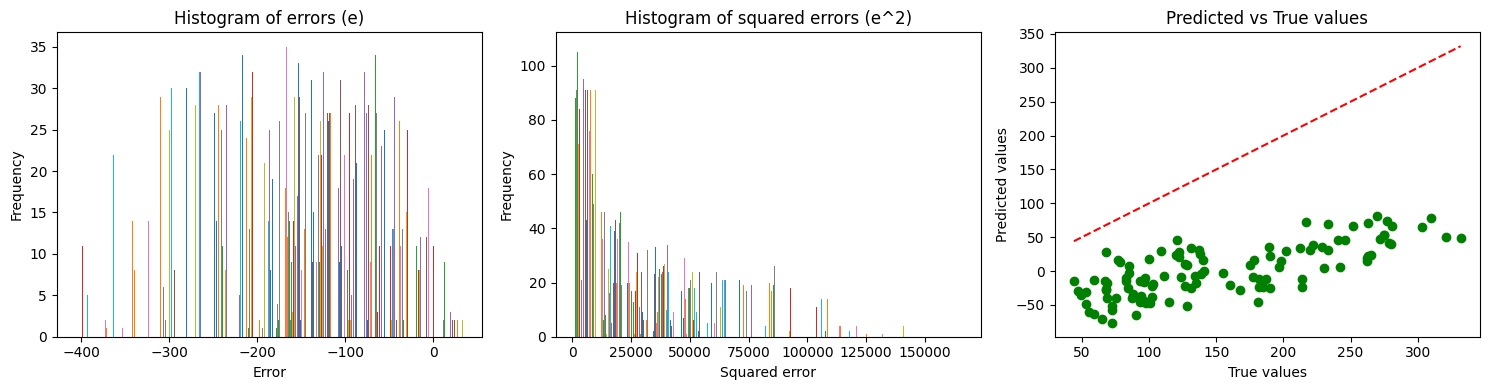

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

def loocv(X, y, C):
    A = X.T @ X + 1/(2*C)*np.identity(X.shape[1])
    A_inv = np.linalg.inv(A)

    # x_i^T*(A^{-1}*X*y)-y_i = X*(A^{-1}*X^T*y)-y
    numerator = (X @ (A_inv @ (X.T @ y))) - y
    # 1- x_i^T*A^{-1}*x_i = 1- X*A^{-1}*X^T
    denominator = 1 - np.sum(X * (X @ A_inv), axis=1, keepdims=True)

    tmp = numerator / denominator

    rmse = np.sqrt(np.mean(tmp*tmp))
    return rmse

def get_w_rr(X, y, C):
    A = (X.T @ X) + 1/(2*C)*np.identity(X.shape[1])
    return np.linalg.inv(A) @ (X.T @ y)

class LOOCVRidge(BaseEstimator, ClassifierMixin):
    def __init__(self, C_candidates, bias=True):
        super(LOOCVRidge, self).__init__()
        
        self.C_candidates = C_candidates
        self.bias = bias
        self.w = None
        
    def fit(self, X, y):
        X = X.copy()
        y = y.reshape(-1, 1)

        best_rmse = float('inf')
        best_C = None
        best_w = None

        # LOOCV für jedes C
        for C in self.C_candidates:
            rmse = loocv(X, y, C)
            if rmse < best_rmse:
                best_rmse = rmse
                best_C = C

        self.w = get_w_rr(X, y, best_C)
        self.best_C = best_C
        return self

    def predict(self, X):
        return X @ self.w
    
# Load Boston Housing dataset
X, Y = load_diabetes(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

# TODO: Run LOOCV for a set of possible values for C
C_candidates = [10**i for i in range(-3, 3+1)]
model_loov = LOOCVRidge(C_candidates)
model_loov.fit(X,Y)
pred = model_loov.predict(X_test)
error = pred - Y_test
sq_error = error**2
print('RMSE on the test set:', np.sqrt(np.mean(sq_error)))
print('w_RR:',  model_loov.w)#, reg[1].w[:-1], 'b:', reg[1].w[-1])


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(error, bins=15)
plt.title('Histogram of errors (e)')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(sq_error, bins=15)
plt.title('Histogram of squared errors (e^2)')
plt.xlabel('Squared error')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.scatter(Y_test, pred, color='green')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.title('Predicted vs True values')
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.tight_layout()
plt.show()
